import

In [1]:
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd

from tqdm.notebook import tqdm as tqdm
from tqdm.auto import trange

import warnings
warnings.filterwarnings("ignore")

from myhelpers import config_plots, TrialStatistics
from HGNN.train import CNN, dataLoader
from HGNN.train.configParser import ConfigParser, getModelName, getDatasetName
from pytorchVisualizations import scorecam, misc_functions
from PIL import Image
from torchvision import transforms

config_plots.global_settings()

experimetnsFileName = "experiments.csv"

parameters

In [2]:
experimentsPath="/home/elhamod/HGNN/experiments/"
dataPath="/data/BGNN_data"
experimentName="biology_paper_datasizes_HGNN_bestLambda" 
# biology_paper_datasizes_HGNN_bestLambda
trial_hash="c2042b5b9fdc257f963dc99d38b0f6cd0e6813c56cee869cbb624f05"
# BB: 164280d6fcb35a84ca89e75ab96fb167d5d036803a2148c5eeb05430
# HGNN best lambda: c2042b5b9fdc257f963dc99d38b0f6cd0e6813c56cee869cbb624f05

img_full_path="/data/BGNN_data/INHS_cropped/images"
fileName= 'INHS_FISH_91030.jpg' # 'INHS_FISH_46448.jpg'# "INHS_FISH_85839.jpg" # "test_INHS_FISH_50076.jpg" # INHS_FISH_106556.jpg
layerName = "hb_hy_features"#"
# "input": x, **
# "hy_features": **
# "hb_features": **
# "hb_hy_features": **
# "gy_features": 
# "gc_features":
# "coarse": 
# "fine": 

cuda=6

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 6


importLoad experiment

In [4]:
config_parser = ConfigParser(experimentsPath, dataPath, experimentName)

experimentPathAndName = os.path.join(experimentsPath, experimentName)

datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)

paramsIterator = config_parser.getExperiments()  
number_of_experiments = sum(1 for e in paramsIterator)  

load dataset and model

In [5]:
# Get experiment parameters
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
experiment_params = experimentRecord.to_dict('records')[0]
print(experiment_params)

# Create the model
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_loader, validation_loader, test_loader = datasetManager.getLoaders()
fineList = test_loader.dataset.csv_processor.getFineList()
coarseList = test_loader.dataset.csv_processor.getCoarseList()
numberOffine = len(fineList)
numberOfcoarse = len(coarseList)
architecture = {
    "fine": numberOffine,
    "coarse" : numberOfcoarse
}
model = CNN.create_model(architecture, experiment_params)

{'experimentName': 'biology_paper_lambda', 'modelName': 'models/c2042b5b9fdc257f963dc99d38b0f6cd0e6813c56cee869cbb624f05', 'datasetName': 'datasplits/1d513fa293ef4e4a37772337043e0e154d87ff0e27f98615149572df', 'experimentHash': 'efc791e8de086bd750eba5551bccdd807a2988f78bfb88aeea8882b0', 'trialHash': 'c2042b5b9fdc257f963dc99d38b0f6cd0e6813c56cee869cbb624f05', 'image_path': 'INHS_cropped', 'suffix': 'biology_paper_cleaned_50max', 'training_count': nan, 'validation_count': nan, 'batchSize': 64, 'n_epochs': nan, 'learning_rate': 5e-05, 'numOfTrials': 5, 'patience': nan, 'fc_width': nan, 'fc_layers': 1, 'modelType': 'HGNN_add', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'augmented': True, 'weight_decay': nan, 'img_res': 448, 'tl_freeze': nan, 'cnn_layers': nan, 'cnn_channels': nan, 'pretrained': nan, 'two_nets': nan, 'link_layer': 'avgpool', 'dataset_norm': nan, 'aug_profile': nan}
Creating datasets...


scanning files: 100%|██████████| 1900/1900 [00:07<00:00, 252.63it/s]


Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


Load model of a specific trial

In [6]:
# get the model and the parameters
modelName = experimentRecord.iloc[0]["modelName"]
trialName = os.path.join(experimentPathAndName, modelName)

df, epochs, time_elapsed = CNN.loadModel(model, trialName)

Generate Score-CAM

In [7]:
score_cam = scorecam.ScoreCam(model, target_layer=layerName)

In [8]:
original =  Image.open(os.path.join(img_full_path, fileName))

image_non_normalized = scorecam.getTransformedImage(test_loader.dataset, original, False, False)
image_normalized = scorecam.getTransformedImage(test_loader.dataset, original, False, True)

if torch.cuda.is_available():
    image_normalized = image_normalized.cuda()

# TODO: handle 'fine' vs 'coarse' later
output = model(image_normalized)['fine']
target_class = torch.max(output, 1)[1]

In [9]:
cam = score_cam.generate_cam(image_normalized, target_class)

Display and save

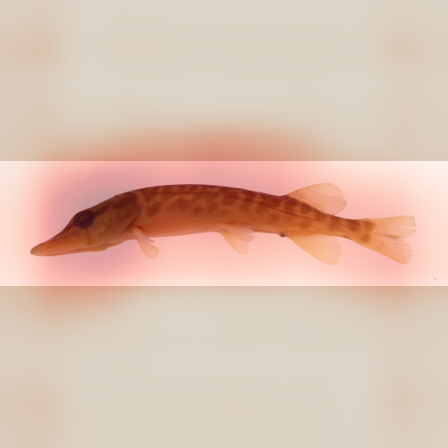

In [10]:
im = transforms.ToPILImage()(image_non_normalized.squeeze()).convert("RGB")
dir_name = os.path.join(experimentsPath, experimentName, "results", trial_hash, 'score_cam')
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
save_name = os.path.join(dir_name, layerName+"_"+fileName)
misc_functions.save_class_activation_images(im, cam, save_name)

In [13]:
print(model.activations(image_normalized)['hb_hy_features'].shape)

torch.Size([1, 512, 14, 14])
